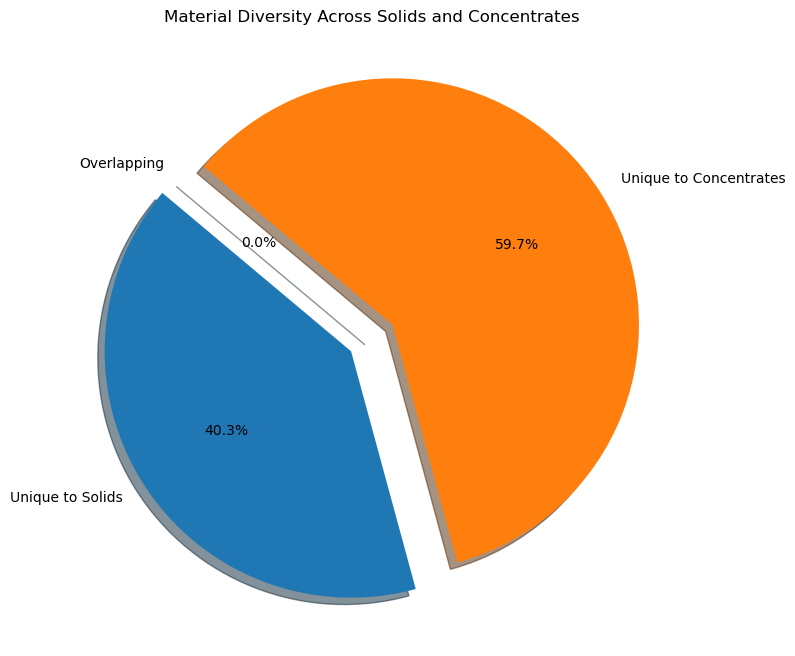

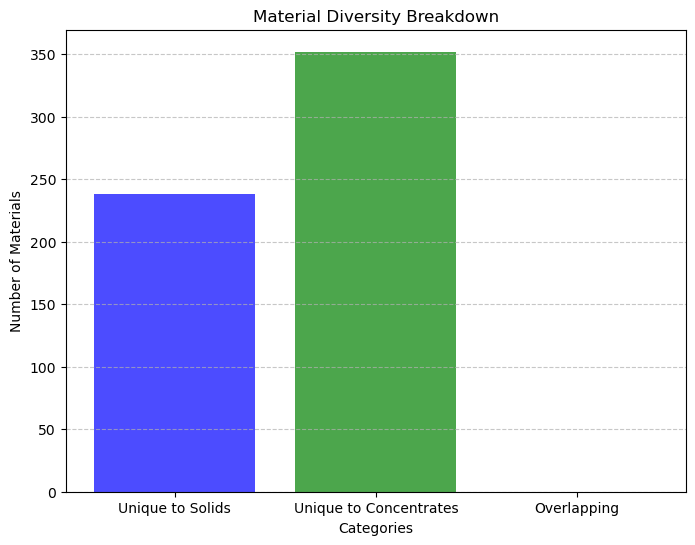

c:\Users\KalakondaNithish\anaconda3\envs\ml-dev\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\KalakondaNithish\anaconda3\envs\ml-dev\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\KalakondaNithish\anaconda3\envs\ml-dev\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\KalakondaNithish\anaconda3\envs\ml-dev\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


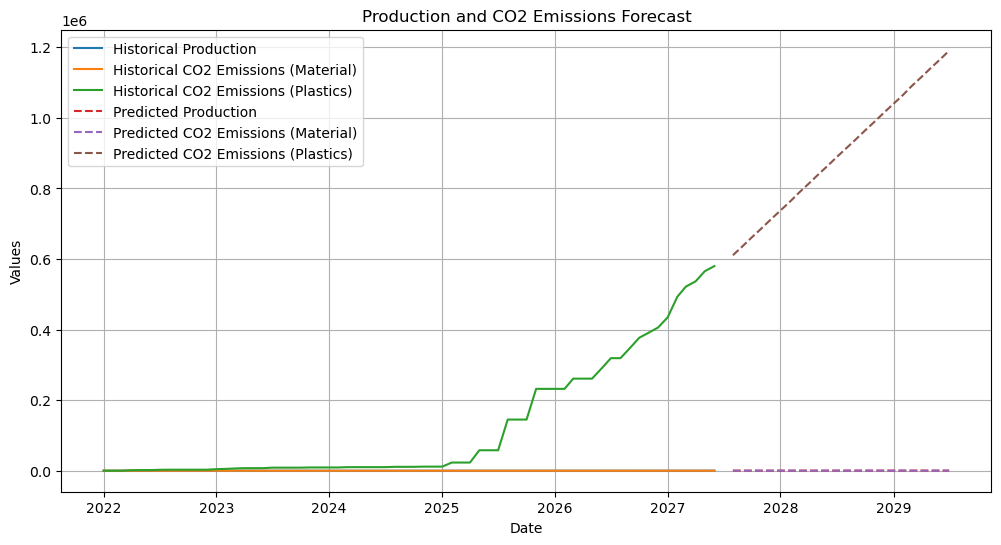

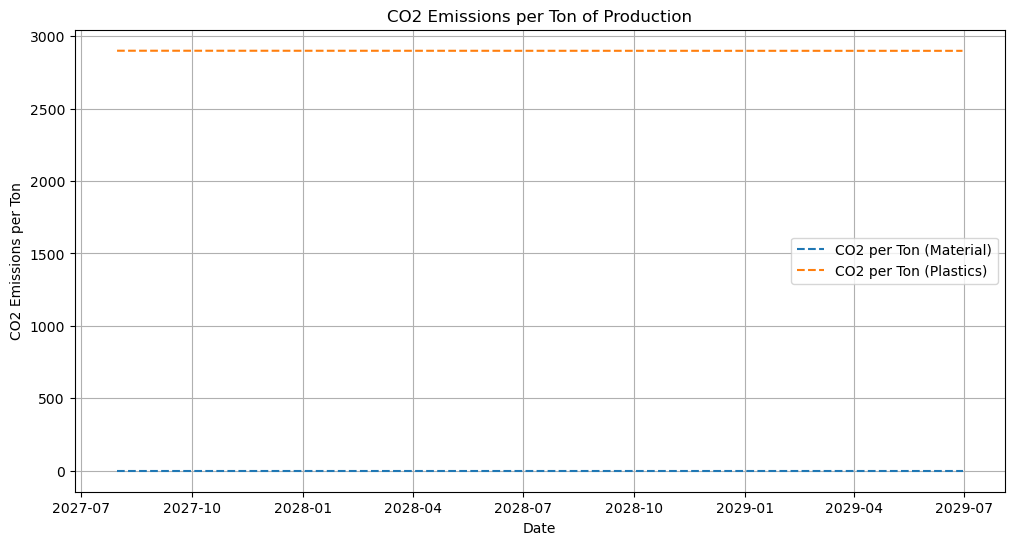

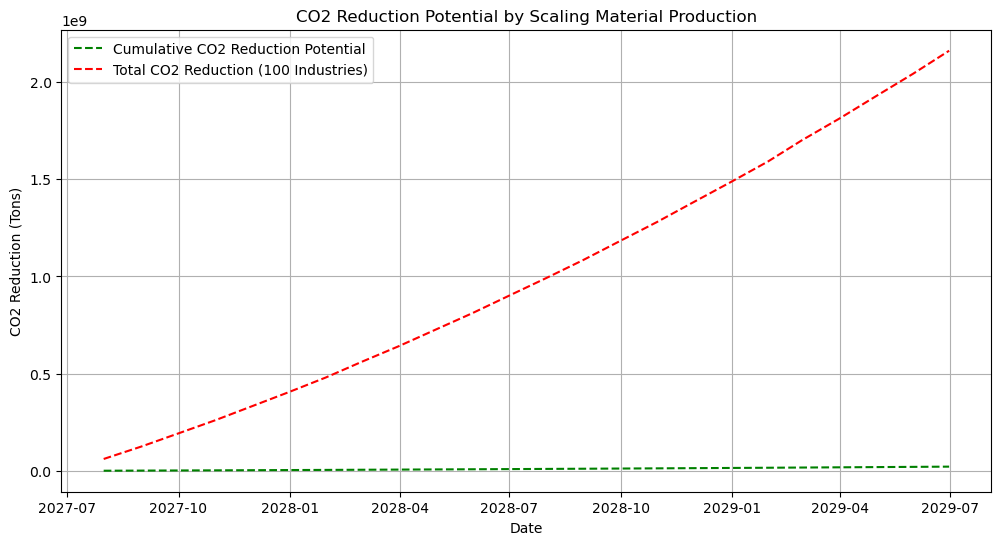

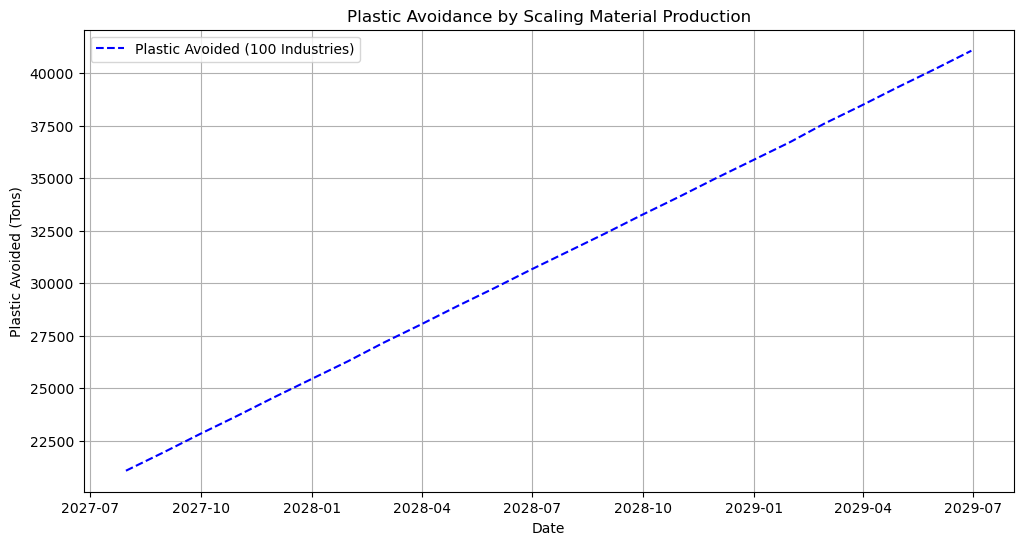


1. Invest in technologies to reduce CO2 emissions relative to production.
2. Shift focus towards scaling material production while decoupling CO2 emissions using advanced engineering solutions.
3. Highlight sustainability metrics to attract environmentally conscious investors.
4. Demonstrate how CO2 emissions per ton for new materials are significantly lower compared to plastics (orders of magnitude difference).
5. Show cumulative CO2 reduction potential as a key metric for scalability.
6. Continue monitoring and refining the production-to-emission ratio to achieve long-term goals.



In [14]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Load the provided Excel files
materials_db_path = 'Data/Materials_DB.xlsx'
data_path = 'Data/Data.xlsx'

materials_db = pd.ExcelFile(materials_db_path)
data = pd.ExcelFile(data_path)

materials_solids = materials_db.parse('Solids')
materials_concentrates = materials_db.parse('Concentrates')
production_data = data.parse('Production')

# Analyze material diversity
solids_materials = materials_solids.iloc[3:, [1]].dropna().rename(columns={"Unnamed: 1": "Material"})
concentrates_materials = materials_concentrates.iloc[2:, [2]].dropna().rename(columns={"Unnamed: 2": "Material"})

solids_count = solids_materials["Material"].nunique()
concentrates_count = concentrates_materials["Material"].nunique()

all_materials = pd.concat([solids_materials, concentrates_materials], ignore_index=True)
all_materials_unique = all_materials["Material"].nunique()

overlap_count = len(set(solids_materials["Material"]).intersection(set(concentrates_materials["Material"])))
unique_solids = solids_count - overlap_count
unique_concentrates = concentrates_count - overlap_count

material_diversity_summary = {
    "Unique Materials (Solids)": solids_count,
    "Unique Materials (Concentrates)": concentrates_count,
    "Total Unique Materials (Combined)": all_materials_unique,
    "Overlapping Materials": overlap_count,
    "Unique to Solids": unique_solids,
    "Unique to Concentrates": unique_concentrates,
}

# Visualize material diversity
categories = ['Unique to Solids', 'Unique to Concentrates', 'Overlapping']
values = [unique_solids, unique_concentrates, overlap_count]

plt.figure(figsize=(8, 8))
plt.pie(
    values,
    labels=categories,
    autopct='%1.1f%%',
    startangle=140,
    explode=(0.1, 0.1, 0),
    shadow=True
)
plt.title("Material Diversity Across Solids and Concentrates")
plt.savefig('material_diversity_pie_chart.png')
plt.show()

plt.figure(figsize=(8, 6))
plt.bar(categories, values, color=['blue', 'green', 'gray'], alpha=0.7)
plt.title("Material Diversity Breakdown")
plt.ylabel("Number of Materials")
plt.xlabel("Categories")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('material_diversity_bar_chart.png')
plt.show()

# Prepare production and CO2 data
production_data['Date'] = pd.to_datetime(production_data['Date'])
production_data.set_index('Date', inplace=True)
production = production_data['TPM'].replace([np.inf, -np.inf], np.nan).dropna()
co2_emissions = production_data['MyBC growth CO2 Produced Tons (1,6 kg per ton)'].replace([np.inf, -np.inf], np.nan).dropna()
plastics_co2_emissions = production_data['Plastic encineration(2.9kg CO2 per kg)'].replace([np.inf, -np.inf], np.nan).dropna()

# Ensure all series have the same length
min_length = min(len(production), len(co2_emissions), len(plastics_co2_emissions))
production = production.iloc[:min_length]
co2_emissions = co2_emissions.iloc[:min_length]
plastics_co2_emissions = plastics_co2_emissions.iloc[:min_length]

# Fit the production data with Exponential Smoothing
production_model = ExponentialSmoothing(production, trend='add', seasonal=None).fit()

# Fit the CO2 data with Exponential Smoothing
co2_model = ExponentialSmoothing(co2_emissions, trend='add', seasonal=None).fit()
plastics_co2_model = ExponentialSmoothing(plastics_co2_emissions, trend='add', seasonal=None).fit()

# Generate future predictions
future_steps = 24
future_dates = pd.date_range(start=production.index[-1], periods=future_steps + 1, freq='M')[1:]

future_production = production_model.forecast(future_steps)
future_co2 = co2_model.forecast(future_steps)
future_plastics_co2 = plastics_co2_model.forecast(future_steps)

# Create DataFrame for future predictions
predictions = pd.DataFrame({
    'Date': future_dates,
    'Predicted Production (TPM)': future_production.values,
    'Predicted CO2 Emissions (Material)': future_co2.values,
    'Predicted CO2 Emissions (Plastics)': future_plastics_co2.values
})

# Calculate CO2 emissions per unit of production
predictions['CO2 per Ton (Material)'] = predictions['Predicted CO2 Emissions (Material)'] / predictions['Predicted Production (TPM)']
predictions['CO2 per Ton (Plastics)'] = predictions['Predicted CO2 Emissions (Plastics)'] / predictions['Predicted Production (TPM)']

# Calculate cumulative CO2 emissions reduction potential
predictions['Cumulative CO2 Reduction'] = (
    predictions['Predicted CO2 Emissions (Plastics)'] - predictions['Predicted CO2 Emissions (Material)']
).cumsum()

# Scaling across 100 industries
industries_count = 100
predictions['Total CO2 Reduction (100 Industries)'] = predictions['Cumulative CO2 Reduction'] * industries_count
predictions['Plastic Avoided (100 Industries)'] = predictions['Predicted Production (TPM)'] * industries_count

# Plot production and CO2 trends
plt.figure(figsize=(12, 6))
plt.plot(production.index, production, label="Historical Production")
plt.plot(production.index, co2_emissions, label="Historical CO2 Emissions (Material)")
plt.plot(production.index, plastics_co2_emissions, label="Historical CO2 Emissions (Plastics)")
plt.plot(predictions['Date'], predictions['Predicted Production (TPM)'], label="Predicted Production", linestyle='--')
plt.plot(predictions['Date'], predictions['Predicted CO2 Emissions (Material)'], label="Predicted CO2 Emissions (Material)", linestyle='--')
plt.plot(predictions['Date'], predictions['Predicted CO2 Emissions (Plastics)'], label="Predicted CO2 Emissions (Plastics)", linestyle='--')
plt.xlabel("Date")
plt.ylabel("Values")
plt.title("Production and CO2 Emissions Forecast")
plt.legend()
plt.grid()
plt.savefig('production_and_co2_forecast.png')
plt.show()

# Plot CO2 emissions per ton
plt.figure(figsize=(12, 6))
plt.plot(predictions['Date'], predictions['CO2 per Ton (Material)'], label="CO2 per Ton (Material)", linestyle='--')
plt.plot(predictions['Date'], predictions['CO2 per Ton (Plastics)'], label="CO2 per Ton (Plastics)", linestyle='--')
plt.xlabel("Date")
plt.ylabel("CO2 Emissions per Ton")
plt.title("CO2 Emissions per Ton of Production")
plt.legend()
plt.grid()
plt.savefig('co2_emissions_per_ton.png')
plt.show()

# Visualize CO2 reduction potential
plt.figure(figsize=(12, 6))
plt.plot(predictions['Date'], predictions['Cumulative CO2 Reduction'], label="Cumulative CO2 Reduction Potential", linestyle='--', color='green')
plt.plot(predictions['Date'], predictions['Total CO2 Reduction (100 Industries)'], label="Total CO2 Reduction (100 Industries)", linestyle='--', color='red')
plt.xlabel("Date")
plt.ylabel("CO2 Reduction (Tons)")
plt.title("CO2 Reduction Potential by Scaling Material Production")
plt.legend()
plt.grid()
plt.savefig('co2_reduction_potential.png')
plt.show()

# Plot plastic avoided
plt.figure(figsize=(12, 6))
plt.plot(predictions['Date'], predictions['Plastic Avoided (100 Industries)'], label="Plastic Avoided (100 Industries)", linestyle='--', color='blue')
plt.xlabel("Date")
plt.ylabel("Plastic Avoided (Tons)")
plt.title("Plastic Avoidance by Scaling Material Production")
plt.legend()
plt.grid()
plt.savefig('plastic_avoided.png')
plt.show()

# Display recommendations based on forecast
recommendations = '''
1. Invest in technologies to reduce CO2 emissions relative to production.
2. Shift focus towards scaling material production while decoupling CO2 emissions using advanced engineering solutions.
3. Highlight sustainability metrics to attract environmentally conscious investors.
4. Demonstrate how CO2 emissions per ton for new materials are significantly lower compared to plastics (orders of magnitude difference).
5. Show cumulative CO2 reduction potential as a key metric for scalability.
6. Continue monitoring and refining the production-to-emission ratio to achieve long-term goals.
'''
print(recommendations)
